In [120]:
using Distributed
using Plots


# Start worker processes. This will typically start as many processes as you have CPU cores.
# You only need to run this cell once per notebook session.
addprocs()

println("Total processes available: $(nprocs()) (1 main + $(nworkers()) workers)")

Total processes available: 25 (1 main + 24 workers)


In [121]:
@everywhere using Primes
@everywhere using Random

@everywhere function count_liftable_lines_robust(n::Int, k::Int, p::Int; M::Int, rng::AbstractRNG=Random.default_rng())
    # --- Step 1: Setup ---
    # The set of coordinates that define a "liftable" vector
    bound = floor(Int, (p - 1) / k)
    k_p_elements_set = union(Set(0:bound), Set((p - bound):(p - 1)))
    
    # Total number of lines in the entire space P^(n-1)(F_p)
    total_lines = (BigInt(p)^n - 1) ÷ (p - 1)

    # --- Step 2: Decide whether to run an exact or sampling computation ---
    if total_lines < M
        # --- A) EXACT COMPUTATION ---
        # This is the reliable method from before, used when it's feasible.
        println("Total lines ($total_lines) < M ($M). Running exact computation...")
        
        liftable_count = BigInt(0)
        # We only need to check vectors made from the special coordinate set
        k_p_elements = collect(k_p_elements_set)
        vector_source = Iterators.product(ntuple(_ -> k_p_elements, n)...)
        seen_vectors = Set{NTuple{n, Int}}()

        for v in vector_source
            if all(iszero, v) || v in seen_vectors
                continue
            end
            liftable_count += 1
            for r in 1:(p-1)
                push!(seen_vectors, ntuple(i -> mod(r * v[i], p), n))
            end
        end
        return (liftable_count, total_lines)

    else
        # --- B) ROBUST SAMPLING ---
        # Sample M lines from the entire space and test each one.
        println("Sampling $M of $total_lines total lines...")
        
        liftable_in_sample = 0
        for _ in 1:M
            # 1. Generate a random line by generating a random non-zero vector
            v = ntuple(_ -> rand(rng, 0:(p-1)), n)
            while all(iszero, v)
                v = ntuple(_ -> rand(rng, 0:(p-1)), n)
            end

            # 2. Check if the line is liftable.
            # A line is liftable if it can be scaled to have all its
            # coordinates in the special k_p set.
            is_liftable = false
            for r in 1:(p-1)
                # Check if r*v is a liftable vector
                scaled_v = ntuple(i -> mod(r * v[i], p), n)
                if all(x -> x in k_p_elements_set, scaled_v)
                    is_liftable = true
                    break # Found a scaling factor, no need to check others
                end
            end
            
            if is_liftable
                liftable_in_sample += 1
            end
        end
        return (liftable_in_sample, M)
    end
end



In [133]:
# 1. Define parameters
n = 6
k = 3
p_1 = 3
p_2 = 300 # Reduced for a quick test
M = 1000000

# 2. Generate the list of primes
println("Generating primes from $p_1 to $p_2...")
prime_list = primes(p_1, p_2)[1:1:end]
println("Found $(length(prime_list)) primes. Starting parallel computation...")

# 3. Define the task for each prime
computation_task = p -> begin
    # This function returns (liftable_found, lines_looked_at)
    liftable, lines_looked_at = count_liftable_lines_robust(n, k, p, M=M)
    
    if lines_looked_at == 0
        return 0.0
    end
    
    # Calculate the proportion of LIFTED lines
    proportion_liftable = Float64(liftable) / Float64(lines_looked_at)
    
    # --- THE FIX IS HERE ---
    # Return the proportion of NON-LIFTED lines to match the old script's output.
    return 1.0 - proportion_liftable
end

# 4. Execute in parallel
V = pmap(computation_task, prime_list)

# 5. Print the results
println("\nResults for the proportion of NON-LIFTED lines with k=$k:")
println(V)

Generating primes from 3 to 300...
Found 61 primes. Starting parallel computation...
      From worker 14:	Total lines (177156) < M (1000000). Running exact computation...
      From worker 16:	Total lines (402234) < M (1000000). Running exact computation...
      From worker 15:	Sampling 1000000 of 1508598 total lines...
      From worker 18:	Total lines (364) < M (1000000). Running exact computation...
      From worker 11:	Total lines (3906) < M (1000000). Running exact computation...
      From worker 12:	Sampling 1000000 of 29583456 total lines...
      From worker 24:	Sampling 1000000 of 6728904 total lines...
      From worker 7:	Total lines (19608) < M (1000000). Running exact computation...
      From worker 21:	Sampling 1000000 of 21243690 total lines...
      From worker 18:	Sampling 1000000 of 10615201506 total lines...
      From worker 10:	Sampling 1000000 of 150508644 total lines...
      From worker 4:	Sampling 1000000 of 71270178 total lines...
      From worker 9:	Sam

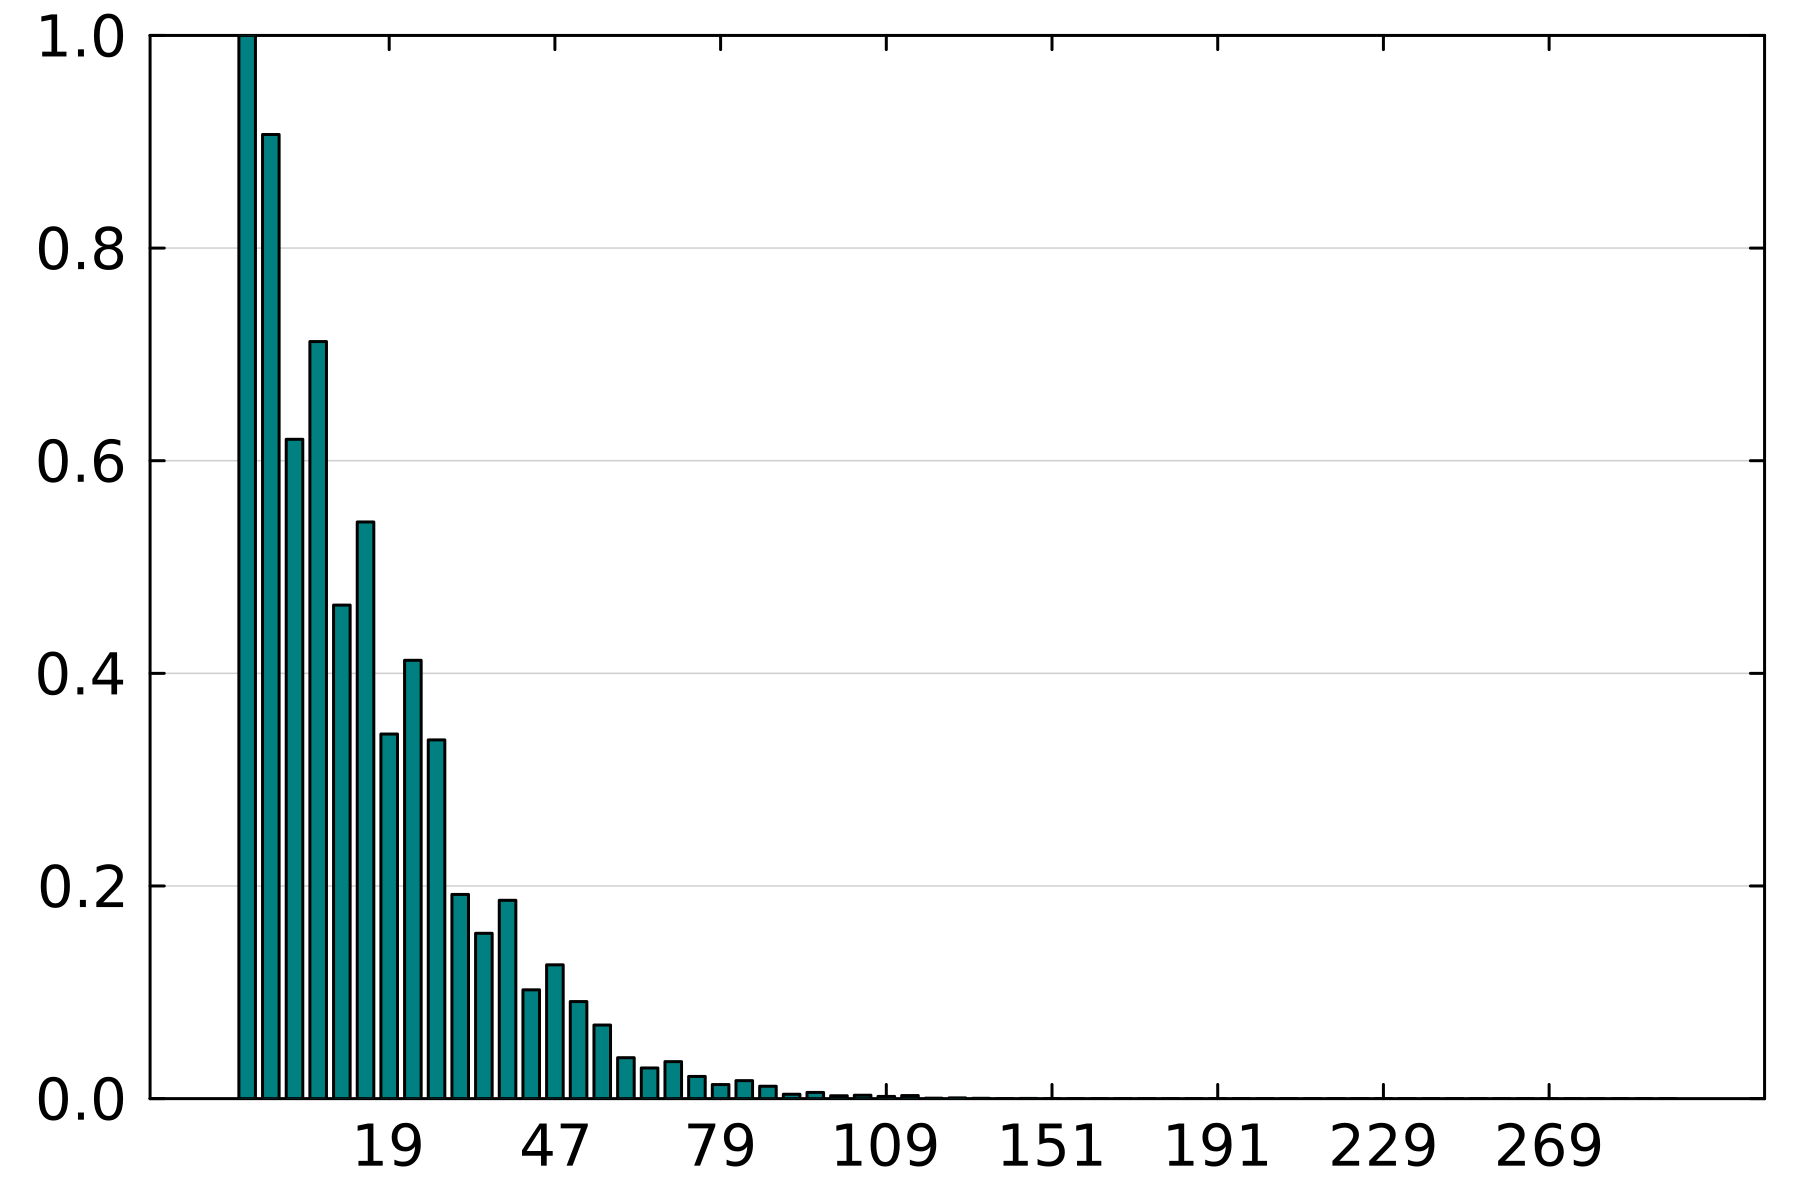

In [134]:
using Plots

"""
Generates a bar plot for a list of proportions `V`, with bars positioned
according to `prime_list`. This function only requires the two lists as input.
"""
function generate_proportion_barplot(prime_list, V)

    # Check that all values in V are valid proportions
    if !all(0 .<= V .<= 1)
        error("All values in the input list V must be between 0 and 1.")
    end

    # Convert numbers to strings for categorical x-axis labels
    x_labels = string.(prime_list)

    # Create the bar plot with a generic title
    plt = bar(x_labels, V,
        #title = "Proportion by Prime", # Generic title without n and k
        #xlabel = "Prime (p)",
        #ylabel = "Proportion",
        legend = false,
        color = :teal,
        bar_width = 0.7,
        grid = :y,
        framestyle = :box,
        ylims = (0, 1), # Keep y-axis fixed to the [0, 1] range
        tickfont = font(13),
        dpi = 300
    )

    # Save the figure to a file
    savefig(plt, "proportion_plot.png")

    # Display the plot
    display(plt)
end



generate_proportion_barplot(prime_list, V)

In [135]:
V

61-element Vector{Float64}:
 1.0
 0.9068100358422939
 0.6201550387596899
 0.7120503962609226
 0.46420740166171925
 0.54238
 0.34292599999999995
 0.412296
 0.337398
 0.19206500000000004
 0.15551000000000004
 0.18655299999999997
 0.10234699999999997
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0